# Generating Player-Based Tables from LiveSum Data

## Part 0: Importing all necessary libraries

In [1]:
import pandas as pd
import json
import re

## Part 1: Preprocessing the Data for use

### Part 1a. Loading Training and Test Data from the JSON Files

In [2]:
with open('train.json') as f:
    train_data = json.load(f)
train_df = pd.json_normalize(train_data)
with open('test.json') as f:
    test_data = json.load(f)
test_df = pd.json_normalize(test_data)

#display the first few rows of the dataframes
display(train_df.head())
display(test_df.head())

,text,table,id
0,And we're off for the start of the first half....,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513261
1,"And we're off, the First Half has kicked off. ...","Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513267
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513268
3,And we're underway in the first half. Player9(...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513270
4,The game is starting with the first half. Play...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513272


,text,table,id
0,And we're off for the first half. Player27(Awa...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513332
1,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513360
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25600389
3,And we're off for the first half. Player26(Awa...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25617902
4,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25892175


### Part 1b. Use the first Training Row to see if we can generate some player-based stats tables

In [3]:
train_row_1 = train_df.iloc[0]
train_comm = train_row_1['text']
print(train_comm)

And we're off for the start of the first half. Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half. Player8(Home Team) commits a foul. Player20(Away Team) earns a free kick on the right side of the field. Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece. The Away Team wins a corner kick. Player2(Home Team) earns a free kick on the right side of the field. Player24(Away Team) commits a foul. Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross. Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team. Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high. Player7(Home Team) commits a fo

In [4]:
#Making it a bit more readable
commentary = train_comm.replace('. ', '.\n')
print(commentary)


And we're off for the start of the first half.
Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half.
Player8(Home Team) commits a foul.
Player20(Away Team) earns a free kick on the right side of the field.
Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece.
The Away Team wins a corner kick.
Player2(Home Team) earns a free kick on the right side of the field.
Player24(Away Team) commits a foul.
Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross.
Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team.
Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high.
Player7(Home Team) commits a fo

### Part 1c. Attempt to extract the Players involved into two separate DataFrames

In [5]:
# Verify the content of the commentary variable
print(commentary)

# Adjust the regex pattern if necessary to match the actual format of the commentary
def extract_team_events(commentary, team_type):
    pattern = rf"Player\d+\s*\({team_type} Team\).*?"
    matches = re.findall(pattern, commentary)
    events = []
    for match in matches:
        player_match = re.search(r"Player\d+", match)
        if player_match:
            player = player_match.group()
            event = match.replace(player, "").strip()
            events.append({"Player": player, "Event": event})
    return pd.DataFrame(events)

# Recreate the DataFrames for home and away teams
home_team_df = extract_team_events(commentary, "Home")
away_team_df = extract_team_events(commentary, "Away")


And we're off for the start of the first half.
Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half.
Player8(Home Team) commits a foul.
Player20(Away Team) earns a free kick on the right side of the field.
Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece.
The Away Team wins a corner kick.
Player2(Home Team) earns a free kick on the right side of the field.
Player24(Away Team) commits a foul.
Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross.
Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team.
Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high.
Player7(Home Team) commits a fo

In [6]:
display(home_team_df.head())

,Player,Event
0,Player10,(Home Team)
1,Player8,(Home Team)
2,Player2,(Home Team)
3,Player6,(Home Team)
4,Player5,(Home Team)


In [7]:
display(away_team_df.head())

,Player,Event
0,Player23,(Away Team)
1,Player20,(Away Team)
2,Player26,(Away Team)
3,Player28,(Away Team)
4,Player24,(Away Team)


### Part 1d. With the players extracted, now we try to add the stats (Shots, Fouls, Yellow Cards, Red Cards, FK, SOG, Shot Accuracy, etc.)

In [29]:
from collections import defaultdict
import pandas as pd
import re

# Initialize dictionaries to store player and team statistics
player_stats = defaultdict(lambda: defaultdict(int))
team_stats = defaultdict(lambda: defaultdict(int))

# Define patterns for player and team statistics
patterns = {
    "Shots": r"(?P<player>Player\d+)\(.*?\).*?shot",
    "Fouls": r"(?P<player>Player\d+)\(.*?\).*?foul",
    "Yellow Cards": r"(?P<player>Player\d+)\(.*?\).*?yellow card",
    "Red Cards": r"(?P<player>Player\d+)\(.*?\).*?red card",
    "Goals": r"(?P<player>Player\d+)\(.*?\).*?scores",
    "Assists": r"assisted by (?P<player>Player\d+)",
    "Offsides": r"(?P<player>Player\d+)\(.*?\).*?offside",
    "Free Kicks": r"(?P<player>Player\d+)\(.*?\).*?free kick",
}

team_patterns = {
    "Goals": r"(?P<team>Home Team|Away Team) .*?scores",
    "Shots": r"(?P<team>Home Team|Away Team).*?shot",
    "Fouls": r"(?P<team>Home Team|Away Team).*?foul",
    "Yellow Cards": r"(?P<team>Home Team|Away Team).*?yellow card",
    "Red Cards": r"(?P<team>Home Team|Away Team).*?red card",
    "Corners": r"(?P<team>Home Team|Away Team).*?corner kick",
    "Free Kicks": r"(?P<team>Home Team|Away Team).*?free kick",
    "Offsides": r"(?P<team>Home Team|Away Team).*?offside",
}

# Extract player statistics
for stat, pattern in patterns.items():
    matches = re.finditer(pattern, commentary)
    for match in matches:
        player = match.group("player")
        player_stats[player][stat] += 1

# Extract team statistics
for stat, pattern in team_patterns.items():
    matches = re.finditer(pattern, commentary)
    for match in matches:
        team = match.group("team")
        team_stats[team][stat] += 1

# Convert player_stats to a DataFrame
player_stats_df = pd.DataFrame.from_dict(player_stats, orient="index").fillna(0).reset_index()
player_stats_df.rename(columns={"index": "Player"}, inplace=True)

# Convert team_stats to a DataFrame
team_stats_df = pd.DataFrame.from_dict(team_stats, orient="index").fillna(0).reset_index()
team_stats_df.rename(columns={"index": "Team"}, inplace=True)

# Split player_stats_df into Home and Away teams
home_team_players = home_team_df["Player"].unique()
away_team_players = away_team_df["Player"].unique()

home_players_df = player_stats_df[player_stats_df["Player"].isin(home_team_players)]
away_players_df = player_stats_df[player_stats_df["Player"].isin(away_team_players)]

# Merge statistics into home_team_df and away_team_df
home_team_df = pd.merge(home_team_df.drop_duplicates(subset="Player"), home_players_df, on="Player", how="left").fillna(0)
away_team_df = pd.merge(away_team_df.drop_duplicates(subset="Player"), away_players_df, on="Player", how="left").fillna(0)
# Drop duplicate columns and rename columns
home_team_df = home_team_df.loc[:, ~home_team_df.columns.duplicated()]
away_team_df = away_team_df.loc[:, ~away_team_df.columns.duplicated()]

# Rename columns to remove suffixes (_x or _y)
home_team_df.columns = [col.split('_')[0] for col in home_team_df.columns]
away_team_df.columns = [col.split('_')[0] for col in away_team_df.columns]


# Display the updated DataFrames
display(home_team_df)
display(away_team_df)
display(team_stats_df)


,Player,Event,Shots,Fouls,Goals,Assists,Free Kicks,Yellow Cards,Offsides
0,Player10,(Home Team),3.0,3.0,0.0,1.0,3.0,0.0,0.0
1,Player8,(Home Team),0.0,3.0,0.0,1.0,2.0,0.0,0.0
2,Player2,(Home Team),0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,Player6,(Home Team),5.0,1.0,1.0,1.0,1.0,0.0,0.0
4,Player5,(Home Team),0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,Player9,(Home Team),0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Player7,(Home Team),1.0,2.0,0.0,0.0,0.0,1.0,0.0
7,Player4,(Home Team),0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,Player11,(Home Team),0.0,1.0,0.0,0.0,2.0,1.0,0.0
9,Player14,(Home Team),0.0,2.0,0.0,0.0,2.0,0.0,0.0


,Player,Event,Shots,Fouls,Goals,Assists,Free Kicks,Yellow Cards,Offsides
0,Player23,(Away Team),0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Player20,(Away Team),0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,Player26,(Away Team),3.0,2.0,1.0,0.0,1.0,0.0,1.0
3,Player28,(Away Team),0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,Player24,(Away Team),0.0,2.0,0.0,0.0,1.0,0.0,0.0
5,Player22,(Away Team),0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,Player25,(Away Team),1.0,2.0,0.0,0.0,0.0,2.0,0.0
7,Player29,(Away Team),1.0,0.0,0.0,1.0,0.0,0.0,0.0
8,Player27,(Away Team),1.0,1.0,0.0,0.0,1.0,0.0,0.0
9,Player21,(Away Team),0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Team,Goals,Shots,Fouls,Yellow Cards,Corners,Free Kicks,Offsides
0,Home Team,1.0,9,14,2,8,14,0.0
1,Away Team,0.0,6,9,3,4,8,1.0


### Part 1e. Extract the 'tables' from the row to find out what the stats should be

In [21]:
# Extract the table string from the first row of train_df
table_string = train_df.iloc[0]['table']

# Split the table string into rows
table_rows = table_string.split('<NEWLINE>')

# Extract the header and data rows
header = table_rows[0].split(',')
data = [row.split(',') for row in table_rows[1:]]

# Create a pandas DataFrame
table_df = pd.DataFrame(data, columns=header)

# Display the DataFrame
display(table_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Corner Kicks,Free Kicks,Offsides
0,Away Team,1,8,10,3,0,4,12,1
1,Home Team,1,13,12,2,0,9,10,0


### Part 1f. Compare the two team-wise dataframes to see how different the LLM Answer is from the ground truth

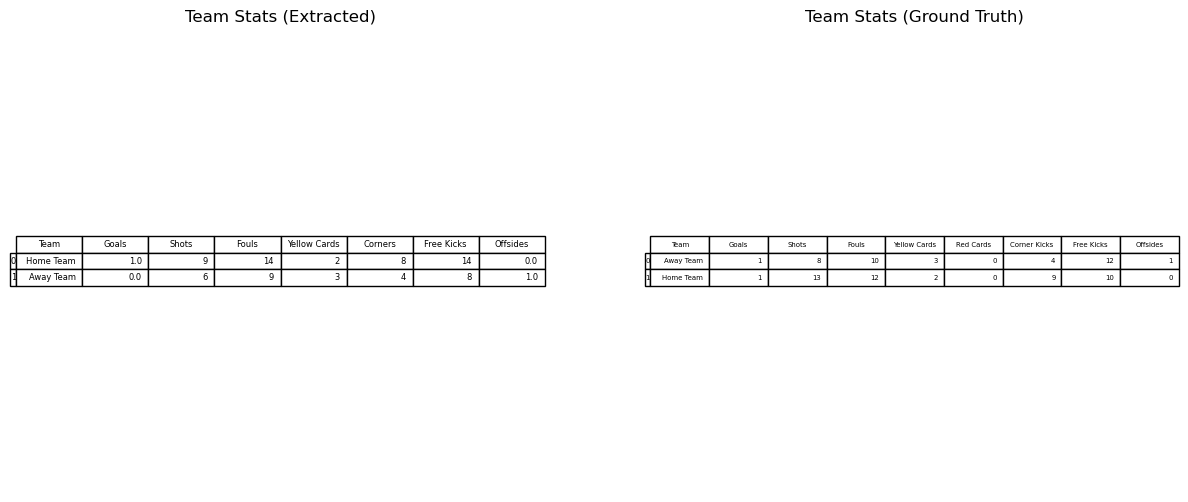

In [23]:
from pandas.plotting import table
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot team_stats_df as a table
axes[0].axis('off')  # Turn off the axis
table(axes[0], team_stats_df, loc='center')  # Add the table
axes[0].set_title('Team Stats (Extracted)')

# Plot table_df as a table
axes[1].axis('off')  # Turn off the axis
table(axes[1], table_df, loc='center')  # Add the table
axes[1].set_title('Team Stats (Ground Truth)')

plt.show()


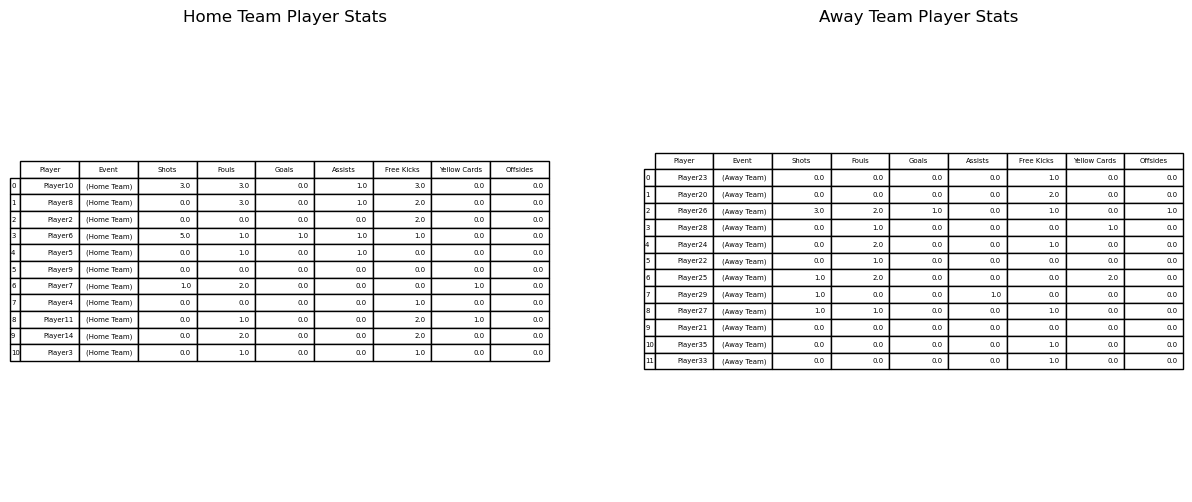

In [31]:
# Create a figure with two subplots for player stats
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot home_team_df as a table
axes[0].axis('off')  # Turn off the axis
table(axes[0], home_team_df, loc='center')  # Add the table
axes[0].set_title('Home Team Player Stats')

# Plot away_team_df as a table
axes[1].axis('off')  # Turn off the axis
table(axes[1], away_team_df, loc='center')  # Add the table
axes[1].set_title('Away Team Player Stats')

plt.show()